In [1]:
import sys
import os
import numpy as np
sys.path.append('..')
from src import NeuralNet
from src import train as fit
from src import make_directory 
from models import load_model
from data import load_data
from six.moves import cPickle
from subprocess import call

np.random.seed(247) # for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
%matplotlib inline
from scipy.misc import imresize

from lasagne import layers, nonlinearities, updates, objectives, init 
from lasagne.layers import Conv2DLayer, TransposedConv2DLayer, DenseLayer, InputLayer, ExpressionLayer, BiasLayer

from lasagne.layers import get_output, get_output_shape, get_all_params
import theano.tensor as T
import theano
np.random.seed(247) # for reproducibility

Using gpu device 0: GeForce GTX 980 (CNMeM is disabled, cuDNN 4007)


In [2]:
filename = 'Unlocalized_N=100000_S=200_M=300_G=30_data.pickle'
datapath = '/home/peter/Data/SequenceMotif'
filepath = os.path.join(datapath, filename)

# load training set
print "loading data from: " + filepath
f = open(filepath, 'rb')
print "loading train data"
train = cPickle.load(f)
print "loading cross-validation data"
cross_validation = cPickle.load(f)
print "loading test data"
test = cPickle.load(f)
f.close()

X_train = train[0].transpose((0,1,2)).astype(np.float32)
y_train = train[1].astype(np.int32)
X_val = cross_validation[0].transpose((0,1,2)).astype(np.float32)
y_val = cross_validation[1].astype(np.int32)
X_test = test[0].transpose((0,1,2)).astype(np.float32)
y_test = test[1].astype(np.int32)

X_train = np.expand_dims(X_train, axis=3)
X_val = np.expand_dims(X_val, axis=3)
X_test = np.expand_dims(X_test, axis=3)

train = (X_train, y_train, train[2])
valid = (X_val, y_val, cross_validation[2])
test = (X_test, y_test, test[2])

shape = (None, train[0].shape[1], train[0].shape[2], train[0].shape[3])
num_labels = train[1].shape[1]

loading data from: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=300_G=30_data.pickle
loading train data
loading cross-validation data
loading test data


In [3]:
model_name = "test_motif_model"
nnmodel = NeuralNet(model_name, shape, num_labels)
nnmodel = fit.train_minibatch(nnmodel, train, valid, batch_size=128, num_epochs=500, 
                        patience=3, verbose=1, filepath=filepath)



Epoch 1 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.10436 -- accuracy=97.08%  
  valid loss:		0.06193
  valid accuracy:	0.98143+/-0.01647
  valid auc-roc:	0.96766+/-0.03969
  valid auc-pr:		0.73829+/-0.24368
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=300_G=30_data.pickle_epoch_0.pickle
Epoch 2 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.05947 -- accuracy=98.12%  
  valid loss:		0.04264
  valid accuracy:	0.98716+/-0.01218
  valid auc-roc:	0.98382+/-0.02447
  valid auc-pr:		0.84111+/-0.19339
saving model parameters to: /home/peter/Data/SequenceMotif/Unlocalized_N=100000_S=200_M=300_G=30_data.pickle_epoch_1.pickle
Epoch 3 out of 500 
[==============================] 100.0% -- time=0s -- loss=0.04568 -- accuracy=98.51%  
  valid loss:		0.03120
  valid accuracy:	0.99009+/-0.01027
  valid auc-roc:	0.99058+/-0.01657
  valid auc-pr:		0.89262+/-0.15238
saving model parameters to: /home/peter/D

KeyboardInterrupt: 

In [4]:
net = nnmodel.network
net

{'conv1': <lasagne.layers.conv.Conv2DLayer at 0x7f7a89291950>,
 'conv1_active': <lasagne.layers.special.NonlinearityLayer at 0x7f7a85c84a90>,
 'conv1_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f7a85c84b10>,
 'conv1_noise': <lasagne.layers.noise.GaussianNoiseLayer at 0x7f7a85c848d0>,
 'conv1_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f7a89291910>,
 'conv1_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f7a85c84ad0>,
 'conv2': <lasagne.layers.conv.Conv2DLayer at 0x7f7a85c84bd0>,
 'conv2_active': <lasagne.layers.special.NonlinearityLayer at 0x7f7a85c903d0>,
 'conv2_dropout': <lasagne.layers.noise.DropoutLayer at 0x7f7a85c90450>,
 'conv2_noise': <lasagne.layers.noise.GaussianNoiseLayer at 0x7f7a85c90210>,
 'conv2_norm': <lasagne.layers.normalization.BatchNormLayer at 0x7f7a85c84b90>,
 'conv2_pool': <lasagne.layers.pool.MaxPool2DLayer at 0x7f7a85c90410>,
 'conv3': <lasagne.layers.conv.Conv2DLayer at 0x7f7a85c90510>,
 'conv3_active': <lasagne.layers.special.Nonlineari

In [5]:

def height_logo(X, I, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # resize nucleotide images for each base of sequence and stack
    num_seq = X.shape[2]
    width = np.ceil(nt_width*num_seq).astype(int)    
    logo = np.ones((height, width, 3)).astype(int)*255;
    nt_height = np.round(height*I).astype(int)

    for i in range(num_seq):
        index = np.argmax(X[0,:,i,0])

        # resized dimensions of image
        if nt_height[i] > 0:
            resize = (nt_height[i], nt_width)
            if index == 0:
                nt_img = imresize(A_img, resize)
            elif index == 1:
                nt_img = imresize(C_img, resize)
            elif index == 2:
                nt_img = imresize(G_img, resize)
            elif index == 3:
                nt_img = imresize(T_img, resize)

            # determine location of image
            height_range = range(height-nt_height[i],height)
            width_range = range(i*nt_width, i*nt_width+nt_width)

            # 'annoying' way to broadcast resized nucleotide image
            if height_range:
                for k in range(3):
                    for m in range(len(width_range)):
                        logo[height_range, width_range[m],k] = nt_img[:,m,k];

    return logo.astype(np.uint8)

In [6]:
import pandas as pd
def seq_logo(pwm, height=100, nt_width=20, norm=0, rna=0, filepath='.'):
    """generate a sequence logo from a pwm"""
    
    def load_alphabet(filepath, rna):
        """load images of nucleotide alphabet """
        df = pd.read_table(os.path.join(filepath, 'A.txt'), header=None);
        A_img = df.as_matrix()
        A_img = np.reshape(A_img, [72, 65, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'C.txt'), header=None);
        C_img = df.as_matrix()
        C_img = np.reshape(C_img, [76, 64, 3], order="F").astype(np.uint8)

        df = pd.read_table(os.path.join(filepath, 'G.txt'), header=None);
        G_img = df.as_matrix()
        G_img = np.reshape(G_img, [76, 67, 3], order="F").astype(np.uint8)

        if rna == 1:
            df = pd.read_table(os.path.join(filepath, 'U.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [74, 57, 3], order="F").astype(np.uint8)
        else:
            df = pd.read_table(os.path.join(filepath, 'T.txt'), header=None);
            T_img = df.as_matrix()
            T_img = np.reshape(T_img, [72, 59, 3], order="F").astype(np.uint8)

        return A_img, C_img, G_img, T_img


    def get_nt_height(pwm, height, norm):
        """get the heights of each nucleotide"""

        def entropy(p):
            """calculate entropy of each nucleotide"""
            s = 0
            for i in range(4):
                if p[i] > 0:
                    s -= p[i]*np.log2(p[i])
            return s

        num_nt, num_seq = pwm.shape
        heights = np.zeros((num_nt,num_seq));
        for i in range(num_seq):
            if norm == 1:
                total_height = height
            else:
                total_height = (np.log2(4) - entropy(pwm[:, i]))*height;
            heights[:,i] = np.floor(pwm[:,i]*total_height);
        return heights.astype(int)

    
    # get the alphabet images of each nucleotide
    A_img, C_img, G_img, T_img = load_alphabet(filepath='.', rna=1)
    
    
    # get the heights of each nucleotide
    heights = get_nt_height(pwm, height, norm)
    
    # resize nucleotide images for each base of sequence and stack
    num_nt, num_seq = pwm.shape
    width = np.ceil(nt_width*num_seq).astype(int)
    
    total_height = np.sum(heights,axis=0)
    max_height = np.max(total_height)
    logo = np.ones((height*2, width, 3)).astype(int)*255;
    for i in range(num_seq):
        remaining_height = total_height[i];
        offset = max_height-remaining_height
        nt_height = np.sort(heights[:,i]);
        index = np.argsort(heights[:,i])

        for j in range(num_nt):
            if nt_height[j] > 0:
                # resized dimensions of image
                resize = (nt_height[j], nt_width)
                if index[j] == 0:
                    nt_img = imresize(A_img, resize)
                elif index[j] == 1:
                    nt_img = imresize(C_img, resize)
                elif index[j] == 2:
                    nt_img = imresize(G_img, resize)
                elif index[j] == 3:
                    nt_img = imresize(T_img, resize)

                # determine location of image
                height_range = range(remaining_height-nt_height[j], remaining_height)
                width_range = range(i*nt_width, i*nt_width+nt_width)

                # 'annoying' way to broadcast resized nucleotide image
                if height_range:
                    for k in range(3):
                        for m in range(len(width_range)):
                            logo[height_range+offset, width_range[m],k] = nt_img[:,m,k];

                remaining_height -= nt_height[j]

    return logo.astype(np.uint8)


In [7]:
def maxunpool(X, pool, active):
    pool_size = active.shape[2]/pool.shape[2]
    fmap1 = []
    for k in range(active.shape[0]):
        x = np.squeeze(active[k],axis=(2,))
        mymap = np.squeeze(pool[k],axis=(2,))

        max_index = []
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            max_index.append(np.argmax(x[:,index],axis=1))
        max_index = np.array(max_index)
        max_index

        dim,seq_length = mymap.shape
        fmap_unpool = np.zeros((dim,seq_length*pool_size))
        for i in range(x.shape[1]/pool_size):
            index = range(i*pool_size,(i+1)*pool_size)
            for j in range(dim):
                fmap_unpool[j,index[max_index[i][j]]] = mymap[j,i]
        fmap1.append(fmap_unpool)

    fmap1 = np.array(fmap1)
    fmap1 = np.expand_dims(fmap1, 3)
    return fmap1 

def deconvolution(fmap, layer):
    # psuedo-inverse filters
    W4 = layer.W.get_value()

    # deconvolution layer 2
    input_var4 = T.tensor4('conv4')
    shape4 = list(fmap.shape)
    shape4[0] = None
    input4 = InputLayer(shape=tuple(shape4), input_var=input_var4)
    #unpool4 = ExpressionLayer(input4, lambda X: T.log(T.exp(X)-1 + 1e-7), output_shape='auto')
    #unpool4 = BiasLayer(unpool4, b=-network['conv2_bias'].b)
    if layer.pad == 'valid':
        pad = 'full'
    else:
        pad = 'same'
    deconv4 = Conv2DLayer(input4, num_filters=layer.input_shape[1],
                                          filter_size=layer.filter_size,
                                          W=layer.W.dimshuffle([1,0,2,3]), #W2_inv, #
                                          b=None, 
                                          pad= 'full' if layer.pad==(0,0) else 'same',
                                          nonlinearity=None, flip_filters=False)
    predict = theano.function([input_var4], get_output(deconv4, deterministic=True), allow_input_downcast=True)

    intermediate = predict(fmap.astype(np.float32))
    return np.array(intermediate)

def get_feature_map_all(layer, input_var, X):
    get_map = theano.function([input_var], get_output(layer), allow_input_downcast=True)
    return get_map(X)

def ImportanceDeconvolution(X, network):

    seq_length = X.shape[2]

    # get dense layer
    get_conv4 = theano.function([nnmodel.input_var], layers.get_output(network['conv4'], deterministic=True), allow_input_downcast=True)
    conv4 = get_conv4(X)
    #MAX = np.max(conv4)
    #conv4 = conv4/MAX
    #conv4 = np.exp(conv4)
    #conv4 = conv4/np.max(conv4)
    conv4[conv4<0.0] = 0

    conv3 = deconvolution(conv4, network['conv4'])
    #MAX = np.max(conv3)
    #conv3 = conv3/MAX
    #conv3 = np.exp(conv3)
    #conv3 =conv3/np.max(conv3)
    #conv3[conv3<0.05] = 0
    conv3[conv3<0.0] = 0

    conv2_pool = deconvolution(conv3, network['conv3'])
    conv2_active = get_feature_map_all(network['conv2'], nnmodel.input_var, X)
    conv2 = maxunpool(X, conv2_pool, conv2_active)
    #MAX = np.max(conv2)
    #conv2 = conv2/MAX
    #conv2 = np.exp(conv2)
    #conv2 =conv2/np.max(conv2)
    #conv2[conv2<0.05] = 0
    conv2[conv2<0.0] = 0

    conv1_pool = deconvolution(conv2, network['conv2'])
    pool = np.squeeze(conv1_pool[0])
    #MAX = np.max(conv1_pool)
    #conv1_pool = conv1_pool/MAX
    #conv1_pool = np.exp(conv1_pool)
    #conv1_pool = conv1_pool/np.max(conv1_pool)
    #conv1_pool[conv1_pool<0.1] = 0
    conv1_pool[conv1_pool<0.0] = 0
    
    conv1_active = get_feature_map_all(network['conv1'], nnmodel.input_var, X)
    conv1 = maxunpool(X, conv1_pool, conv1_active)
    reconstruction = deconvolution(conv1, network['conv1'])

    pwm = np.squeeze(reconstruction[0])

    return pwm

In [8]:
import theano
import theano.tensor as T
import lasagne
def compile_saliency_function(net):
    """
    Compiles a function to compute the saliency maps and predicted classes
    for a given minibatch of input images.
    """
    inp = net['input'].input_var
    outp = lasagne.layers.get_output(net['output'], deterministic=True)
    max_outp = T.max(outp, axis=1)
    saliency = theano.grad(max_outp.sum(), wrt=inp)
    max_class = T.argmax(outp, axis=1)
    return theano.function([inp], [saliency, max_class])

In [9]:
train_fn = compile_saliency_function(net)

In [10]:
class ModifiedBackprop(object):

    def __init__(self, nonlinearity):
        self.nonlinearity = nonlinearity
        self.ops = {}  # memoizes an OpFromGraph instance per tensor type

    def __call__(self, x):
       
        cuda_var = theano.sandbox.cuda.as_cuda_ndarray_variable
        x = cuda_var(x)
        tensor_type = x.type
        
        if tensor_type not in self.ops:
            input_var = tensor_type()
            output_var = cuda_var(self.nonlinearity(input_var))
            op = theano.OpFromGraph([input_var], [output_var])
            op.grad = self.grad
            self.ops[tensor_type] = op

        return self.ops[tensor_type](x)
    
class GuidedBackprop(ModifiedBackprop):
    def grad(self, inputs, out_grads):
        (inp,) = inputs
        (grd,) = out_grads
        dtype = inp.dtype
        return (grd * (inp > 0).astype(dtype) * (grd > 0).astype(dtype),)



In [12]:
relu_layers

In [13]:
relu = nonlinearities.rectify
modified_relu = GuidedBackprop(relu)  # important: only instantiate this once!

relu_layers = [layer for layer in layers.get_all_layers(net['output'])
               if getattr(layer, 'nonlinearity', None) is relu]
for layer in relu_layers:
    layer.nonlinearity = modified_relu


In [15]:

saliency_fn = compile_saliency_function(net)

# Compare normalization methods

ground truth = 27
prediction = 27


/home/peter/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


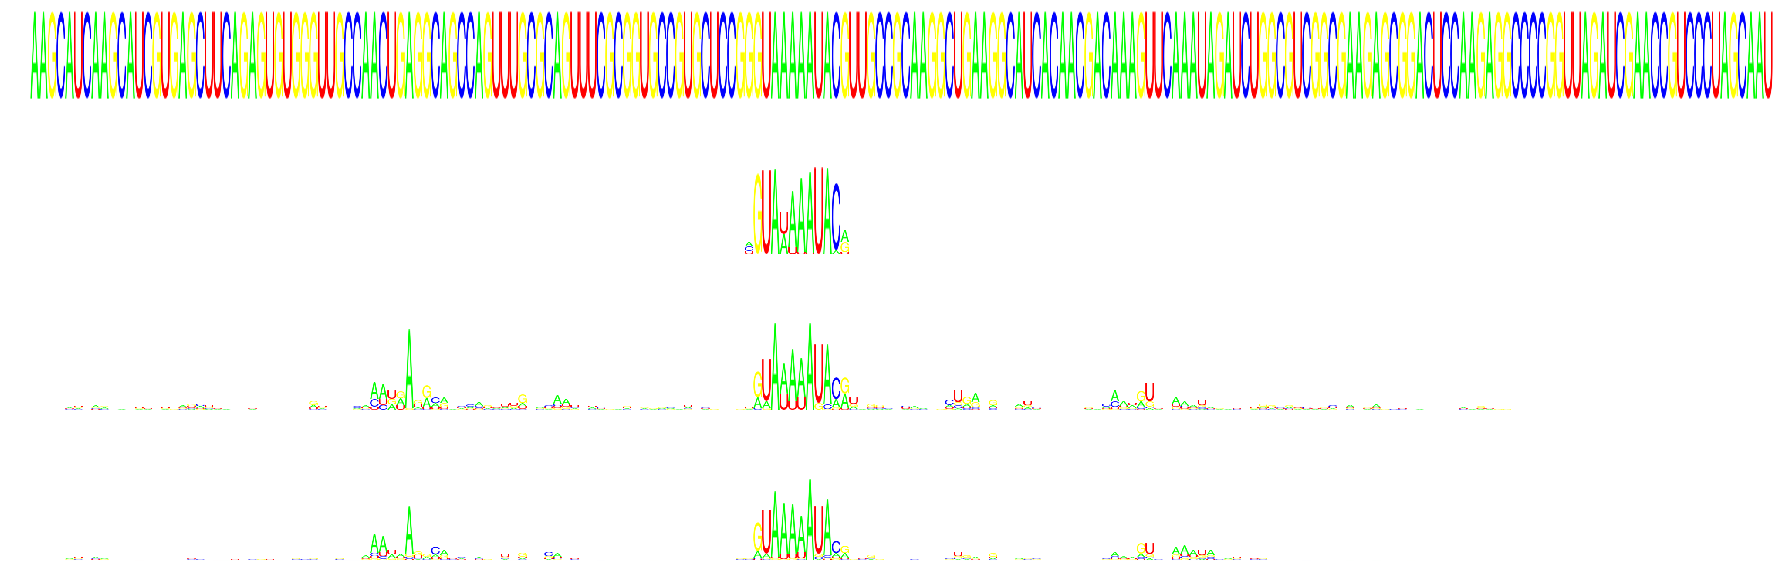

In [16]:
map_index = 2217

X = test[0][map_index]
X = np.expand_dims(X,0).astype(np.float32)
y = test[1][map_index].astype(np.float32)
model = test[2][map_index]


# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))


def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))*1.25
    pwm += .25
    pwm[pwm<0] = 1e-6
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm


grad = train_fn(X)
saliency, max_class = saliency_fn(X)

height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=0, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(4,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(4,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm3=ImportanceDeconvolution(X,net)
pwm3=normalize_pwm(pwm3)

plt.subplot(4,1,3)
logo = seq_logo(pwm3, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm4=ImportanceDeconvolution(X,net)
pwm4=normalize_pwm2(pwm4)

plt.subplot(4,1,4)
logo = seq_logo(pwm4, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


# Compare saliency methods

In [2]:
map_index = 784

X = test[0][map_index]
X = np.expand_dims(X,0).astype(np.float32)
y = test[1][map_index].astype(np.float32)
model = test[2][map_index]


# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))


def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm


grad = train_fn(X)
saliency, max_class = saliency_fn(X)

height=100
bp_width=20
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=0, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(5,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');


plt.subplot(5,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');

pwm = np.copy(np.squeeze(grad[0]))
pwm=normalize_pwm2(pwm)

plt.subplot(5,1,3)
logo = seq_logo(pwm, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');

pwm2 = np.copy(np.squeeze(saliency[0]))
pwm2=normalize_pwm2(pwm2)

plt.subplot(5,1,4)
logo = seq_logo(pwm2, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm3=ImportanceDeconvolution(X,net)
pwm3=normalize_pwm2(pwm3)

plt.subplot(5,1,5)
logo = seq_logo(pwm3, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');




NameError: name 'test' is not defined

# Saliency -- sequence height by information

In [ ]:


map_index = 200

X = test[0][map_index]
X = np.expand_dims(X,0).astype(np.float32)
y = test[1][map_index].astype(np.float32)
model = test[2][map_index]


# get prediction
get_prediction = theano.function([nnmodel.input_var], layers.get_output(net['output'], deterministic=True), allow_input_downcast=True)
prediction = get_prediction(X)
print 'ground truth = ' + str(np.argmax(y))
print 'prediction = ' + str(np.argmax(prediction))



def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .25
    pwm[pwm<0] = 0
    pwm += 0.001
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm


def normalize_pwm2(pwm):
    MAX = np.max(pwm)
    pwm = pwm/MAX*4
    pwm = np.exp(pwm)
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm
    return pwm


height=50
bp_width=15
size = (25.,10.0)

logo = seq_logo(np.squeeze(X[0]), height, bp_width, norm=0, rna=0, filepath='.')
fig = plt.figure(figsize=size);

plt.subplot(5,1,1)
plt.imshow(logo, interpolation='none');
plt.axis('off');

plt.subplot(5,1,2)
logo = seq_logo(model, height, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


#height=400
#bp_width=50
pwm = np.squeeze(grad[0])
pwm = normalize_pwm2(pwm)
I = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2

plt.subplot(5,1,3)
logo = height_logo(X, I, height*2, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm = np.squeeze(saliency[0])
pwm = normalize_pwm2(pwm)
I2 = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2

plt.subplot(5,1,4)
logo = height_logo(X, I2, height*2, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');


pwm=ImportanceDeconvolution(X,net)
pwm = normalize_pwm2(pwm)
I3 = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2


plt.subplot(5,1,5)
logo = height_logo(X, I3, height*2, bp_width, norm=0, rna=0, filepath='.')
plt.imshow(logo, interpolation='none');
plt.axis('off');





In [ ]:
def normalize_pwm(pwm):
    pwm = pwm/np.max(np.abs(pwm))
    pwm += .2
    pwm[pwm<0] = 0
    pwm += 0.001
    #pwm = pwm - np.min(pwm)+1e-6
    norm = np.outer(np.ones(4), np.sum(pwm, axis=0))
    pwm = pwm/norm    
    return pwm

pwm = np.squeeze(grad[0])
pwm = normalize_pwm(pwm)
I = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2
plt.figure()
plt.plot(I,'b')

pwm = np.squeeze(saliency[0])
pwm = normalize_pwm(pwm)
I2 = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2
plt.plot(I2,'g')

pwm=ImportanceDeconvolution(X,net)
pwm = normalize_pwm(pwm)
I3 = (2-np.sum(-pwm*np.log2(pwm),axis=0))/2

plt.plot(I3,'r')


In [ ]:
pwm=ImportanceDeconvolution(X,net)
pwm = pwm/np.max(np.abs(pwm))
pwm = pwm - np.min(pwm)+1e-3

plt.plot(pwm.T)

In [ ]:
plt.figure()
plt.plot(np.squeeze(grad[0]).T)

plt.figure()
plt.plot(np.squeeze(saliency[0]).T)


pwm=ImportanceDeconvolution(X,net)
plt.figure()
plt.plot(pwm.T)
